In [1]:
city   = 'london'
infile = '../ProcessedData/' + city + '/venues_info/venues_time_series.dat'

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from scipy.stats import spearmanr
from collections import Counter

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 
    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())

def round_unix_date(dt_series, seconds=60, up=False):
    return dt_series // seconds * seconds + seconds * up


## GET THE AVG NORMALIZED TIME SERIES

In [10]:
def get_venues_times(infile, month = 1, length = 100):

    longest     = {}

    for ind, line in enumerate(open(infile)):
        fields = line.strip().split('\t')
        venue  = fields[0]
        times  = sorted([ round_unix_date(float(fff), month*30*24*60*60) for fff in fields[1:]])
        x, y = zip(* sorted([(k, v) for k, v in dict(Counter(times)).items()], key=lambda tup: tup[0]))       
        if len(x) > length:
              longest[venue] = (x,y)

    return longest
    
    
    
def get_avg_counts(infile, month):

    times_count = {}
    for ind, line in enumerate(open(infile)):
        times  = [ round_unix_date(float(fff), month*30*24*60*60) for fff in line.strip().split('\t')[1:]]
        for time in times:
            if time not in times_count:
                times_count[time] = 1
            else:
                times_count[time] += 1   

    return times_count    



def completing_timeseries(timeseriesdict, all_times):
    
    timeseriesdict_out = {}
    
    for ind, (ven, (time, cnt)) in enumerate(timeseriesdict.items()):

        mint   =  min(time)
        time_x =  []
        cnt_x  =  []

        for ind, t in enumerate(all_times):
            if t > mint:
                if t in time:
                    time_x.append(t)
                    cnt_x.append(cnt[time.index(t)])
                else:
                    time_x.append(t)
                    cnt_x.append(0)

        x, y = zip(* sorted([(k, v) for k, v in zip(time_x, cnt_x)], key=lambda tup: tup[0]))       
    
        timeseriesdict_out[ven] = (x,y)      

    return timeseriesdict_out



def normalize_time_series(timeseries, timeseries_avg, total_avg):   
    
    venues_times_norm = {}

    for ind, (ven, (times, cnts)) in enumerate(timeseries.items()):
        
        tt = []
        cc = []
        
        for i in range(len(times)):
            normcnt  = float(cnts[i]) / timeseries_avg[times[i]] * total_avg
            tt.append(times[i])
            cc.append(normcnt)
            
        venues_times_norm[ven] = (tt, cc)


    venues_times_norm_norm = {}
    for ind, (ven, (times, cnt)) in enumerate(venues_times_norm.items()):
        maxcnt = np.mean(cnt)
        cnt    = [cc/maxcnt for cc in cnt] 
        venues_times_norm_norm[ven] = (times, cnt)

            
    return venues_times_norm_norm



def viz_timeseries(timeseries, ttitle):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        if ind == 1000: break
        time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
        ax.plot(time_, cnt_, '-', linewidth = 0.1225)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()

In [11]:
longest_1m_12           = get_venues_times(infile, month = 1, length = 6)
avg_times_count_1m_12   = get_avg_counts(infile, month = 1)
total_avg               = np.mean(avg_times_count_1m_12.values())
all_times               = sorted(avg_times_count_1m_12.keys())
longest_1m_12_norm      = normalize_time_series(longest_1m_12, avg_times_count_1m_12, total_avg)
longest_1m_12_full      = completing_timeseries(longest_1m_12, all_times)
longest_1m_12_full_norm = normalize_time_series(longest_1m_12_full, avg_times_count_1m_12, total_avg)



In [4]:
len(longest_1m_12)

20682

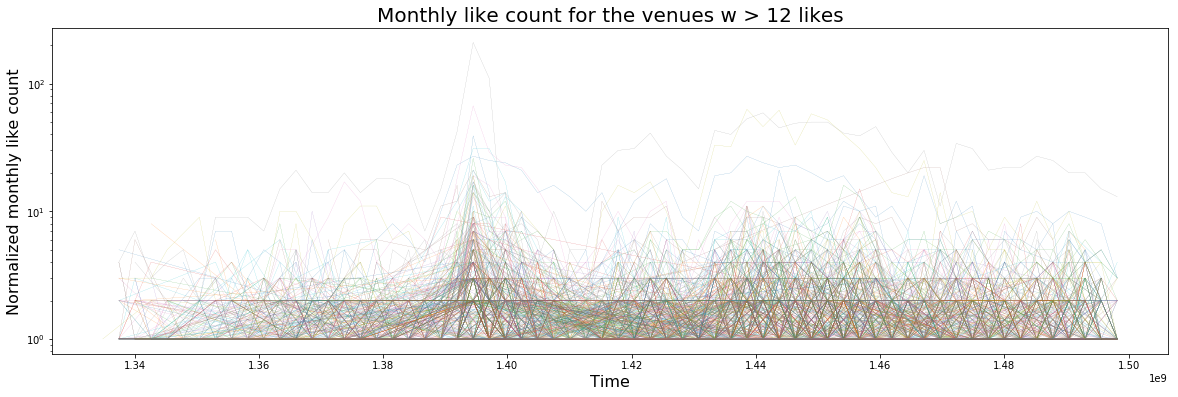

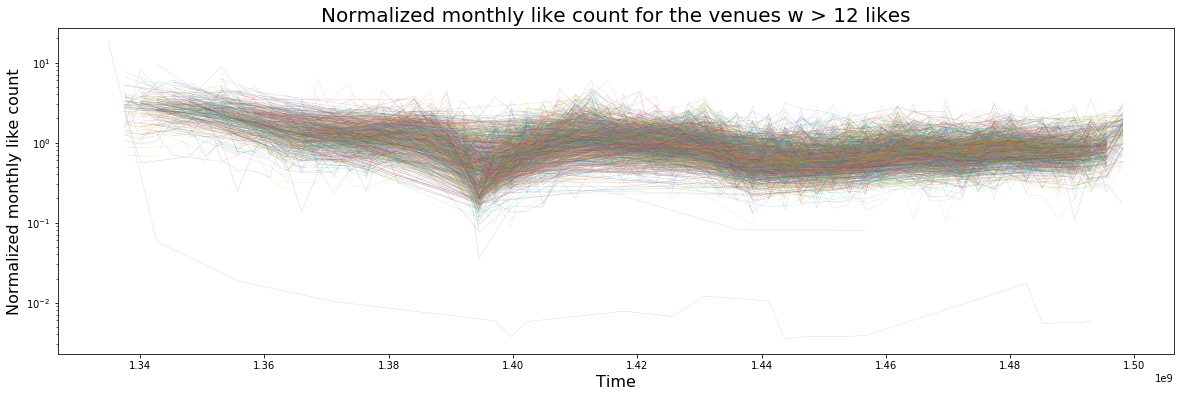

In [12]:
viz_timeseries(longest_1m_12, 'Monthly like count for the venues w > 12 likes')
viz_timeseries(longest_1m_12_norm, 'Normalized monthly like count for the venues w > 12 likes')

In [13]:
x = [5, 10, 20, 30, 40, 50, 70, 95, 100, 120]
y = []
for lng in [5, 10, 20, 30, 40, 50, 70, 95, 100, 120]:
    longest = get_venues_times(infile, length = lng)
    y.append(len(longest))    

Text(0.5,0,'Min length of time series')

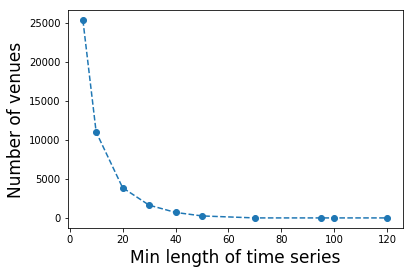

In [10]:
plt.plot(x, y, 'o--')
plt.ylabel('Number of venues', fontsize = 17)
plt.xlabel('Min length of time series', fontsize = 17)

## GROUP VENUES BASED ON AGE

In [14]:
# get the age of the venues
venues_age = {}
for ind, (venue, (time, count)) in enumerate(longest_1m_12.items()):
    venues_age[venue] = (max(time) - min(time) ) / (60*60*24*365)


Text(0.5,0,'Age of the venues')

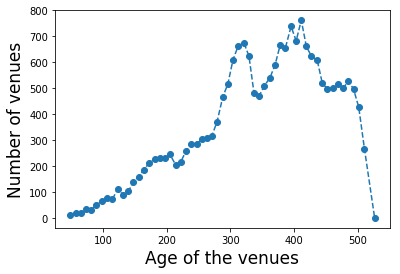

In [15]:
xx, yy = getDistribution( [round(100*v) for v in venues_age.values()], False)

plt.plot(xx, yy, 'o--')
plt.ylabel('Number of venues', fontsize = 17)
plt.xlabel('Age of the venues', fontsize = 17)

In [17]:
df_venues_ages = pd.DataFrame.from_dict(venues_age, orient='index')
df_venues_ages = df_venues_ages.rename(columns = {0 : 'age'})
df_venues_ages.index.name = 'venue'
df_venues_ages.head()

,age
venue,
4f649467e4b0dc7720150594,3.945205
4b043c50f964a520685222e3,4.767123
4b9a63d1f964a5202ab135e3,3.205479
4c472232972c0f471ac52221,2.958904
4b766710f964a5201e4b2ee3,3.041096


In [38]:
df_venues_ages['quartile'] = pd.qcut(df_venues_ages['age'], 5, ['q1','q2','q3','q4', 'q5'])
Q1 = list(df_venues_ages[df_venues_ages['quartile'] == 'q1'].index)
Q2 = list(df_venues_ages[df_venues_ages['quartile'] == 'q2'].index)
Q3 = list(df_venues_ages[df_venues_ages['quartile'] == 'q3'].index)
Q4 = list(df_venues_ages[df_venues_ages['quartile'] == 'q4'].index)
Q5 = list(df_venues_ages[df_venues_ages['quartile'] == 'q5'].index)

Qs = [Q1, Q2, Q3, Q4, Q5]

okvenues = Q4 + Q5
venues_age

{'4f649467e4b0dc7720150594': 3.9452054794520546,
 '4b043c50f964a520685222e3': 4.767123287671233,
 '4b9a63d1f964a5202ab135e3': 3.2054794520547945,
 '4c472232972c0f471ac52221': 2.958904109589041,
 '4b766710f964a5201e4b2ee3': 3.041095890410959,
 '4af7375cf964a5203c0722e3': 4.3561643835616435,
 '4cfa5b40c51fa1cd332ce02b': 3.5342465753424657,
 '4e5fd59fb0fb754192cffc44': 4.191780821917808,
 '50d37093e4b0aa088d0810d8': 3.041095890410959,
 '49b094fdf964a520c8521fe3': 4.3561643835616435,
 '4b643e67f964a52015a62ae3': 3.863013698630137,
 '4bbd047e8a4fb713a77c3c9d': 4.027397260273973,
 '4f06c1f0e4b0e53f582b66be': 4.027397260273973,
 '4ac518daf964a520c9a820e3': 4.684931506849315,
 '4c16b8fbdaf42d7f14a24466': 4.438356164383562,
 '4a27033bf964a520d2841fe3': 2.958904109589041,
 '54b124ee498e1fbc29b025a3': 1.726027397260274,
 '4fe49e6fe4b02bd5c5dc2438': 3.5342465753424657,
 '5264012511d2caed0b5578aa': 2.8767123287671232,
 '52516a7a11d250f3dae3807e': 3.780821917808219,
 '5091656d3950422ec224fdb2': 4.27

Text(0.5,0,'Age of the venues')

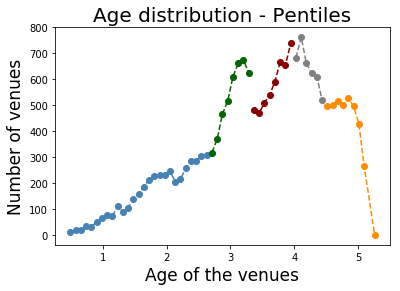

In [39]:
def get_x_y_age(venues_age, Q, c):

    xx   = [a for v, a in venues_age.items() if v in Q]
    x, y = getDistribution(xx, False)
    plt.plot(x, y, 'o--', color = c)
    
colors = ['steelblue', 'darkgreen', 'darkred', 'grey', 'darkorange']
    
for c, Q in zip(colors, Qs):
     get_x_y_age(venues_age, Q, c)

#get_x_y_age(venues_age, venues, 'r')        
        
        
plt.title('Age distribution - Pentiles', fontsize = 20)
plt.ylabel('Number of venues',  fontsize = 17)
plt.xlabel('Age of the venues', fontsize = 17)

7593 20682


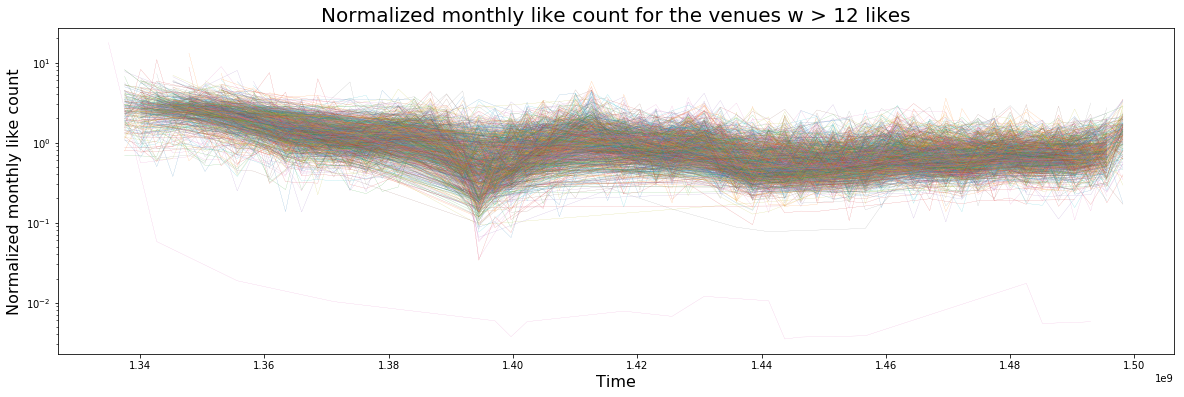

In [58]:
# filter the dictionaries

longest_1m_12_norm_Q3Q4 = {ven : data for ven, data in  longest_1m_12_norm.items() if ven in okvenues}    
    
print len(longest_1m_12_norm_Q3Q4), len(longest_1m_12_norm)    
viz_timeseries(longest_1m_12_norm_Q3Q4, 'Normalized monthly like count for the venues w > 12 likes')


# TIME-RESCALING TIMESEREs (~stretching)

In [59]:
def transform_ts(x, maxTT):

    minx = min(x)  
    x    = [xx - minx for xx in x] 
    maxx = max(x)
    x    = [xx * maxTT / maxx for xx in x]
    
    return x

maxTT = max(max(c[0]) for c in longest_1m_12.values())

In [86]:
longest_1m_12_norm_Q3Q4_stretched = {}

for ind, (venue, (time, count)) in enumerate(longest_1m_12_norm_Q3Q4.items()):
    longest_1m_12_norm_Q3Q4_stretched[venue] = (tuple(transform_ts(time, maxTT)), count) 

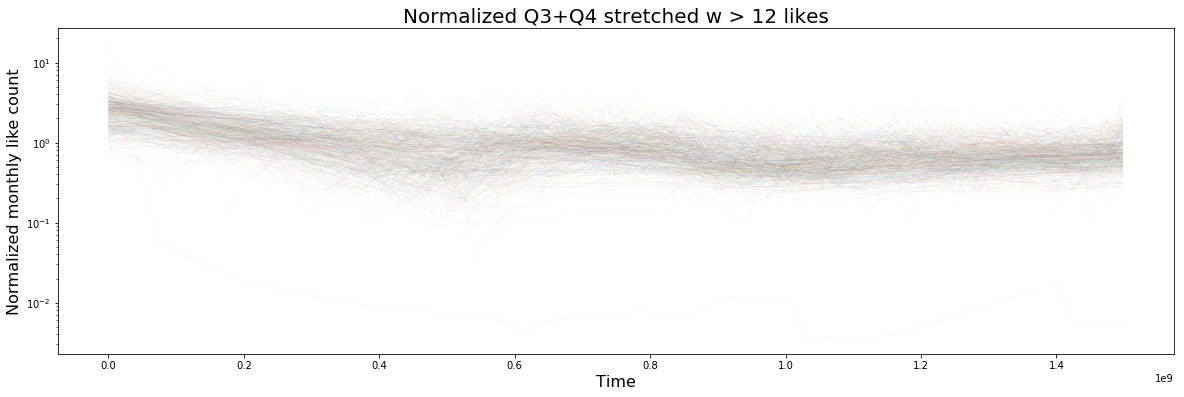

In [88]:

def viz_timeseries2(timeseries, ttitle):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        if ind == 500: break
        time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
        ax.plot(time_, cnt_, '-', linewidth = 0.05225, alpha = 0.5)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()


viz_timeseries2(longest_1m_12_norm_Q3Q4_stretched, 'Normalized Q3+Q4 stretched w > 12 likes')

# GET SIMILARITY MATRICES

In [28]:
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt
from numpy.linalg import norm
import random




In [89]:
def viz_timeseries3(timeseries, ttitle, venues):
    
    f, ax = plt.subplots(1, 1, figsize=(20, 6))

    for ind, (ven, times) in enumerate(timeseries.items()):

        if ven in venues:
            time_, cnt_ = zip(*[(t,c) for t,c in zip(*times) if c < 1000])
            ax.plot(time_, cnt_, '-', linewidth = 0.5225, alpha = 0.95)


    ax.set_yscale('log')
    ax.set_xlabel('Time',fontsize = 16)
    ax.set_ylabel('Normalized monthly like count',fontsize = 16)
    ax.set_title(ttitle, fontsize = 20)

    plt.show()

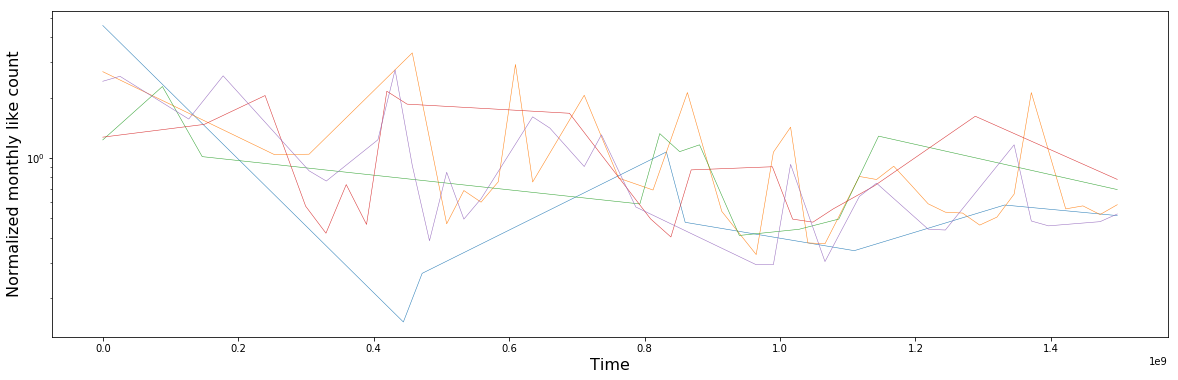

In [63]:
venues = ['4ac518f3f964a5209fae20e3', '51605f56e4b024efa71a9873', '4ac518cef964a520f8a520e3', '4bd0432a9854d13a6855f74d']
viz_timeseries3(longest_1m_12_norm_Q3Q4_stretched, '', random.sample(longest_1m_12_norm_Q3Q4_stretched.keys(), 5))

In [64]:
tss = [np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[v])).reshape(-1, 1) for v in venues]

In [65]:
for i, t1 in enumerate(tss[0:2]):
    for j, t2 in enumerate(tss[0:2]):
        if i != j: 
            dist, cost, acc, path = dtw(t1, t2, dist=norm)
            print i, j, dist

TypeError: 'module' object is not callable

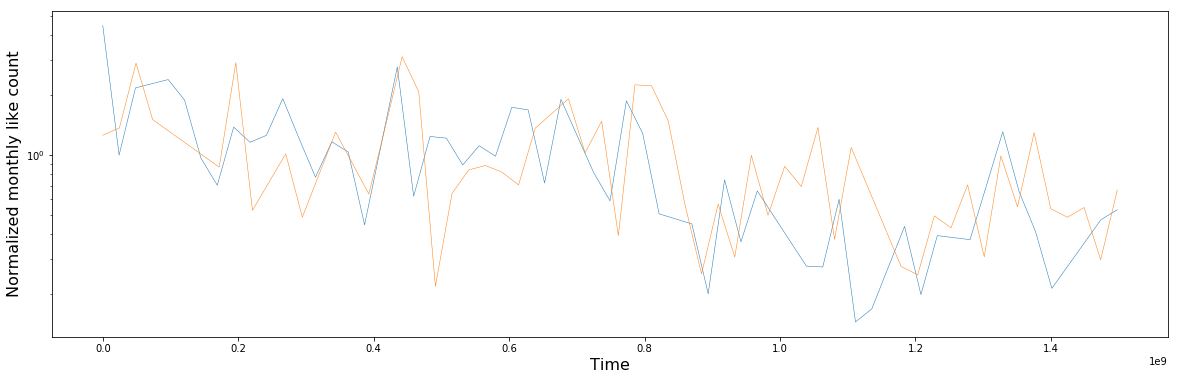

In [99]:

viz_timeseries3(longest_1m_12_norm_Q3Q4_stretched, '', ['4ac518baf964a52006a220e3', '4acd9febf964a52069cc20e3'])

2988


(array([2460., 1679., 1042.,  851.,  488.,  404.,  281.,  165.,  141.,
          82.]),
 array([ 7. , 12.6, 18.2, 23.8, 29.4, 35. , 40.6, 46.2, 51.8, 57.4, 63. ]),
 <a list of 10 Patch objects>)

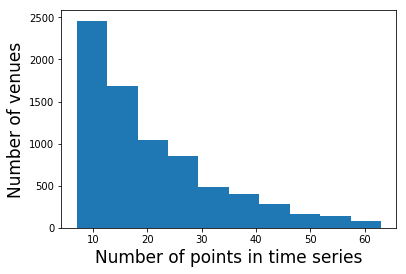

In [109]:
length_distr = {}

v_60 = []
for v , (c,t) in longest_1m_12_norm_Q3Q4_stretched.items():
    
    lng = len(c)
    #if lng not in length_distr:
    #    length_distr[lng] = 1
    #else:
    length_distr[v] = lng
    if len(c) > 20:
        v_60.append( v )

        
print len(v_60)
plt.ylabel('Number of venues',               fontsize = 17)
plt.xlabel('Number of points in time series', fontsize = 17)
plt.hist(length_distr.values())        

In [111]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
import random 
#s2 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[random.sample(v_60,1)
s1 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[ random.sample(v_60,1)[0] ][1])).reshape(-1, 1)
s2 = np.asarray(list(longest_1m_12_norm_Q3Q4_stretched[ random.sample(v_60,1)[0] ][1])).reshape(-1, 1)






#path = dtw.warping_path(s1, s2)
#dtwvis.plot_warping(s1, s2, path, filename="warp.png")

fout = open('TIMESERIES4.DAT', 'w')
gout = open('TIMESERIES_tims.dat', 'w')
for v in v_60:
    
    fout.write( '\t'.join([str(fff) for fff in list(longest_1m_12_norm_Q3Q4_stretched[ v ][1])])+ '\n')
    gout.write( '\t'.join([str(fff) for fff in list(longest_1m_12_norm_Q3Q4_stretched[ v ][0])])+ '\n')

fout.close()
gout.close()